# Build, test and deploy a Stable Diffusion 2 endpoint

This notebook is a walkthrough of how to take a Stable Diffusion checkpoint from Hugging Face, wrap serving code around it, and create a Docker image which makes the endpoint portable and easy to deploy in different machines. 

The container created will be made available in the Graphcore public registry on Dockerhub and can be used to directly launch a deployment locally or through a Container as a service (CaaS) platform. 

Here, we'll cover:
* Cloning and running up the FastAPI service from this notebook to create a locally hosted endpoint.
* How to access and send requests to the endpoint and receive model output.
* How to build a container image and push it to a registry.
* How to deploy a container and access the model endpoint.

The public model inference images available on Graphcore's Docker Hub have all of the necessary dependencies 'baked in', including executables and model binaries, to make the process of serving up an endpoint launch with minimal warm-up time. The internals of the image are based on the [api-deployment](https://github.com/graphcore/api-deployment) repository. This is designed to be a straightforward example of serving a model with FastAPI and running up a local endpoint. Once you've tested your local endpoint functionality, you can use the same container to launch up a deployment on your target server!

First, install all required dependencies for this notebook:

In [1]:
! # # Buildah installation:https://fabianlee.org/2022/08/02/buildah-installing-buildah-and-podman-on-ubuntu-20-04/
! chmod +x setup.sh
! ./setup.sh > /dev/null
! buildah version

! pip install gradient
! pip install gradio
! pip install matplotlib

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
gpg: no valid OpenPGP data found.
W: GPG error: http://download.opensuse.org/repositories/devel:/kubic:/libcontainers:/stable/xUbuntu_20.04  InRelease: The following signatures couldn't be verified because the public key is not available: NO_PUBKEY 4D64390375060AA4
E: The repository 'http://download.opensuse.org/repositories/devel:/kubic:/libcontainers:/stable/xUbuntu_20.04  InRelease' is not signed.


E: Unable to locate package buildah
E: Unable to locate package podman
sed: can't read /usr/share/containers/containers.conf: No such file or directory
sed: can't read /etc/containers/storage.conf: No such file or directory
/bin/bash: buildah: command not found
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 9.1 MB/s eta 0

## Clone the repo

First, clone the repository containing Stable Diffusion and the files for serving.

In [2]:
# ! git clone https://github.com/graphcore/stable-diffusion
!pwd

/notebooks/stable-diffusion-2/notebook


The repo contains all of the basic necessities for serving an endpoint using stable diffusion. The `Dockerfile` specifies requirements and builds and runs the Docker container, `src` contains the model and model specific requirements, the FastAPI based endpoint for the model, and the model-independent files for creating the server. `run_server.sh` is a script to launch the server, which can be run directly or runs automatically as part of the docker container. 

In [3]:
# !cd /notebooks/sd/stable-diffusion-2/notebook/
!pip install -r ../requirements.txt && pip install -r ../src/models/stable_diffusion_2_txt2img_512/requirements.txt


Looking in links: https://download.pytorch.org/whl/cpu/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 48.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.6/222.6 kB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.0/604.0 kB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 34.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 23.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.3/772.3 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 13.5 MB/s eta 0:00:00
   

## Run a local endpoint

While building the container with all features/executables baked in is needed for launching a public Paperspace deployment, it is not a necessary step if you want to test and run the endpoint locally, as we can do this directly from the repo using the `run_server.sh` script. 

First, install all of the dependencies for serving the model, as well as for the model itself.

The terminal output when running the server is 'endless', and will block the above cell from ending, so for the purpose of the notebook we run the server as a background process. Once this command is run, the endpoint server will start warming up, performing any necessary preparation required to use the endpoint, such as building the model executables or creating and loading any other required binaries.

In [ ]:
# We will download a pre-compiled computational graph execution to speed up our compilation
from huggingface_hub import hf_hub_download
hf_hub_download(repo_id="internetoftim/gc-sd2", filename="exe_cache/stable-diffusion-512-v2-1_pod8/210126882926148441.popef")


In [8]:
# Without a precompiled executable, compilation of this model may take around 10-15 minutes.
# An executable can be loaded in the directory where the model pipeline will search `src/exe_cache` order to skip compilation for a shorter warmup time.
# This example writes on /tmp so it gets flushed upon shutdown, manage cache files accordingly.


!mkdir -p ../src/exe_cache/stable-diffusion-512-v2-1_pod8/
!ln -s /tmp/huggingface_caches/models--internetoftim--gc-sd2/snapshots/0346b5ba24bf41cf58879c5787fdf0311c00cfae/exe_cache/stable-diffusion-512-v2-1_pod8/* ../src/exe_cache/stable-diffusion-512-v2-1_pod8/

In [ ]:
cd stable-diffusion-2/ && ./run_server.sh &

In [ ]:
# When you run the server, a compiled graph is required, you will need to download this
# Download the graph compilation
# <TODO> Put an image of the Model pipeline and discuss why it is getting split up


In either instance, we need to wait for the server to be ready before actually sending any requests to the endpoint. We can wait for the built-in server health-check feature to return a positive status using a simple looping function. For Stable Diffusion, this step may take up to a few minutes. First, import the necessary packages for the function:

In [9]:
import requests
import json
import random
import time

Then we can instantiate our simple function which waits for the readiness status:

In [10]:
# ```python:
def wait_for_readiness(url):
    while True:
        try:
            response = requests.get(f"{url}/readiness")
            response = response.json()
            if response['message'] == 'Readiness check succeeded.': 
                print(f"Server ready - {response['message']}")
                break
            else:
                print(f"Server waiting - {response['message']}")
                raise Exception
        except Exception as e:
            time.sleep(2)
    return True
# ```

Next, we time and call the function:

In [11]:
print("Waiting for readiness...")

warmup_start = time.perf_counter()
ready = wait_for_readiness("http://0.0.0.0:8100")

print(f"Warm up time: {time.perf_counter() - warmup_start}s")

Waiting for readiness...
Server ready - Readiness check succeeded.
Warm up time: 0.011846820823848248s


The message should say 'Readiness check succeeded', which means we are ready to start generating images with the model using the live endpoint.

Lets create a dictionary for the parameters to send to the model. This is specific to and defined by the model endpoint that has been created. For Stable Diffusion, we must pass:

* `prompt`: Main body of text describing the image we want to create.
* `random_seed`: Can be used to emulate a deterministic image output from the same prompt each time (we set this to random to observe variation in the image).
* `guidance scale`: Specific to Stable Diffusion, it controls how strongly the generated image will follow the text output.
* `return_json`: Defines whether to return a JSON object in the response or not, to receive an encoded image, we want to set this to True.
* `negative_prompt`: Defines any aspects we don't want to see in the image.
* `num_inference_steps`: The number of sampling steps undertaken by the model, increasing this up to a point should improve the image quality of the generated image, 25-50 steps is a reasonable range for this.

In [12]:
model_params = {
      "prompt": "big red dog",
      "random_seed": random.randint(0,99999999),
      "guidance_scale": 9,
      "return_json": True,
      "negative_prompt": "string",
      "num_inference_steps": 25
}

Next, we can use `requests` to send a POST call to the REST endpoint at the IP address that the endpoint is running on. This will return an image in the response JSON body.

In [13]:
response = requests.post("http://0.0.0.0:8100/stable_diffusion_2_txt2img_512", json=model_params)

if response.status_code != 200:
    print(response.status_code)
    
response = response.json()

Now, the image has been returned in Base64 encoded form within the JSON, we can decode this using the `base64` and `io` libraries to visualise the image. First, we decode the images returned by the model and convert them to PIL RGB images - in this case there is only one image.

In [14]:
from PIL import Image
import base64
import io

images_b64 = [i for i in response['images']]

pil_images = []
for b64_img in images_b64:
    base64bytes = base64.b64decode(b64_img)
    bytesObj = io.BytesIO(base64bytes)
    img = Image.open(bytesObj)
    
    pil_images.append(img)
    
print("Number of images returned: ", len(pil_images))

Number of images returned:  1


Finally, we can view the images with `matplotlib`:

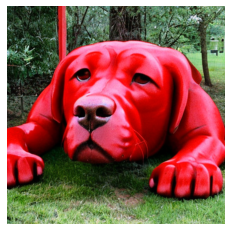

In [15]:
import matplotlib.pyplot as plt

plt.axis('off')
plt.imshow(pil_images[0])
plt.show()

## Build Container Image

To have a portable deployment in different platforms, it is recommended to build a container image which includes server files and model that were used previously to run the local endpoint. The container image could be uploaded to a container registry so that deployment would be simply pulling the image and running the endpoint.


### (Optional) Build and upload the image manually

In a local workspace, to build the container we can simply run:
```
docker build -t <local_container_name> .
```
From the root directory of the repository.

In this example, I will show how to use an alternative container manager to build the image with the available user privileges. For this purpose, we can use `buildah` and `podman` to run Docker-equivalent commands on a container. To build the container, we can use `buildah bud` rather than `Docker build` as such:

In [19]:
! buildah bud -t local-sd2-endpoint stable-diffusion/

32000

Next, tag the image with the name of your Dockerhub registry and the name with which to upload the image.

In [26]:
username = input(prompt="Enter your Dockerhub username")

Enter your Dockerhub username timotdsantos


In [27]:
container_name = input(prompt="Enter an image name for the container to be uploaded to your Dockerhub registry")

Enter an image name for the container to be uploaded to your Dockerhub registry sd2


In [28]:
! buildah tag local-sd2-endpoint $username/$container_name

32000

Finally, push the built image to your personal Dockerhub registry.

In [29]:
! buildah push docker.io://$username/$container_name

32000

## (Optional) Create a simple demo frontend for your deployment with **Gradio**

You can create a create an easy frontend demo for your deployment using Gradio. All you need is the URL of your deployment, and a simple function to process the Stable Diffusion 2 input parameters, request the model and decode the output image - the same process we set out for the local endpoint earlier:

This notebook points by default to the locally hosted endpoint. If you would like to run the Gradio app with the launched Paperspace deployment, change the following cell to point to the generated Paperspace deployment URL.

In [16]:
URL = "http://0.0.0.0:8100"

In [17]:
import gradio as gr
import numpy as np

def stable_diffusion_2_inference(prompt, guidance_scale, num_inference_steps):
    model_params = {
      "prompt": prompt,
      "random_seed": random.randint(0,99999999),
      "guidance_scale": guidance_scale,
      "return_json": True,
      "negative_prompt": "string",
      "num_inference_steps": num_inference_steps
    }
    
    response = requests.post(f"{URL}/stable_diffusion_2_txt2img_512", json=model_params)
    response = response.json()
    
    images_b64 = [i for i in response['images']]
    pil_images = []
    for b64_img in images_b64:
        base64bytes = base64.b64decode(b64_img)
        bytesObj = io.BytesIO(base64bytes)
        img = Image.open(bytesObj)

        pil_images.append(img)
    
    return np.array(pil_images[0])

Then, we can initialise the Gradio app to launch a GUI from inside this notebook by defining our inputs, outputs and the processing function:

In [18]:
gr.close_all()
demo = gr.Interface(
    fn=stable_diffusion_2_inference, 
    inputs=[gr.Textbox(value="Ice skating on the moon"),
            gr.Slider(1,50,value=9, step=1, label='Guidance scale'),
            gr.Slider(1,100,value=25, step=1, label='Number of steps')
           ], 
    outputs=gr.Image(shape=(512,512))
    )

demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://b79bd1724483b4e43b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [19]:
# !sudo apt -y update && sudo apt -y install snapd

# Try sending a curl command from outside the notebook

https://ngrok.com/

`ngrok` is a tool that creates a secure tunnel from the public internet to a local server on your machine. 
This will let you access this API endpoint that is within this notebook environment, as if it were a server.


In [20]:
# Download and install NGROK
!curl -s https://ngrok-agent.s3.amazonaws.com/ngrok.asc | \
  sudo tee /etc/apt/trusted.gpg.d/ngrok.asc >/dev/null && \
  echo "deb https://ngrok-agent.s3.amazonaws.com buster main" | \
  sudo tee /etc/apt/sources.list.d/ngrok.list && \
  sudo apt update && sudo apt install ngrok

deb https://ngrok-agent.s3.amazonaws.com buster main
Hit:1 http://security.ubuntu.com/ubuntu focal-security InRelease               
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease                         
Hit:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease                 
Hit:4 http://archive.ubuntu.com/ubuntu focal-backports InRelease               
Get:5 https://ngrok-agent.s3.amazonaws.com buster InRelease [20.3 kB]          
Get:6 https://ngrok-agent.s3.amazonaws.com buster/main amd64 Packages [2410 B] 
Err:7 http://download.opensuse.org/repositories/devel:/kubic:/libcontainers:/stable/xUbuntu_20.04  InRelease
  Cannot initiate the connection to download.opensuse.org:80 (2001:67c:2178:8::13). - connect (101: Network is unreachable) Could not connect to download.opensuse.org:80 (195.135.221.134), connection timed out
Fetched 22.7 kB in 36s (623 B/s)                              
Reading package lists... Done
Building dependency tree       
Reading state informati

In [18]:
# Let us listen to the port 8100, the port we have set in our FastAPI code
# You can uncomment this cell to run ngrok, or copy it on the terminal
# !ngrok http 8100



7=ngrok                                                           (Ctrl+C to quit)                                                                                Session Status                connecting                                        Version                       3.3.0                                             Latency                       -                                                 Web Interface                 http://127.0.0.1:4040                                                                                                             Connections                   ttl     opn     rt1     rt5     p50     p90                                     0       0       0.00    0.00    0.00    0.00                                                                                                                                                                                                                                                                                        

![](../ngrok.png)

In [22]:
# You can sign up for an ngrok account to be able to serve an html file and see the /docs

!ngrok config add-authtoken <your token>


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [28]:
# <NGROK-URL>/stable_diffusion_2_txt2img_512

# {
#       "prompt": "big red dog",
#       "random_seed": 31337,
#       "guidance_scale": 9,
#       "return_json": false,
#       "negative_prompt": "string",
#       "num_inference_steps": 25
# }


!curl -X POST --output ./test.jpg -H "Content-Type: application/json"  -d '{ "prompt": "big red dog", "random_seed": 31337, "guidance_scale": 9, "return_json": false, "negative_prompt": "string",      "num_inference_steps": 25}' https://<NGROK APP URI>/stable_diffusion_2_txt2img_512



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  361k  100  361k  100   152  48610     19  0:00:08  0:00:07  0:00:01 85810  0 --:--:--  0:00:01 --:--:--     0


You can run this on postman using the following request:

https://NGROK_APP_URI/stable_diffusion_2_txt2img_512

{
      "prompt": "big red dog",
      "random_seed": 31337,
      "guidance_scale": 9,
      "return_json": false,
      "negative_prompt": "string",
      "num_inference_steps": 25
}

![](../postman.png)